 Metin Madenciligi Dersi
 
 Nefret Soylemi ve Ofansif Dil Problemi
 - Oguzhan KANDAKOGLU
 - Elif Yildirim

 Bu calisma dort farkli yontem uzerinde denenmistir.
 - Logistic Regression
 - Linear SVC (Support Vector Classification)
 - Naive Bayes
 - Random Forest


  Son kisimda uc farkli siniflandirma algoritmasinin (classifier) da performansi gosterilmektedir.

# Gerekli Araclarin Dahil Edilmesi

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem.porter import *

import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS

from textstat.textstat import *

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline


# Veri setinin yuklenmesi

In [2]:
with open("data/labeled_data.p", 'rb') as f:
    df = pd.read_pickle(f)

In [3]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.describe()


,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [5]:
df.columns


Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

# Kolon Yapisi

count = Her tweetin kac adet CrowdFlower kullanicisi tarafindan etiketlendiginin sayisi. (Her tweet en az 3 adet kullanici tarafindan etiketlenmistir.)

hate_speech = Kac CF kullanicisinin tweeti 'Nefret Soylemi' olarak etiketlediginin sayisi.

offensive_language = Kac CF kullanicisinin tweeti 'Ofansif Dil' olarak etiketlediginin sayisi.

neither = Kac CF kullanicisinin tweeti 'Ne Nefret Soylemi ne de Ofansif Dil' olarak etiketlediginin sayisi.

# Siniflandirma Yapisi

    0 - Nefret Soylemi
    1 - Ofansif Dil
    2 - Neither



<AxesSubplot:>

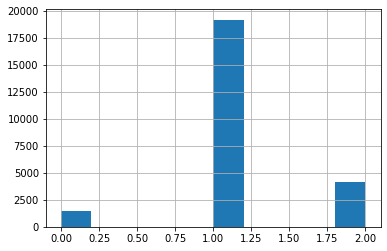

In [6]:
df['class'].hist()

# Metin Koleksiyonunun Belirlenmesi

Histogram uzerinden de goruldugu gibi 'Ofansif Dil' kullanilmis tweetlerin sayisi cok daha fazla. 'Ne Ofansif Dil ne de Nefret Soylemi' barindiran tweetler ise 'Nefret Soylemi' barindiran tweetlerden daha fazla.

Bu durum 'Metin Madenciligi' icin cok da olumlu bir durum degil. Ancak buradan soyle bir sonuc cikarabiliriz.
Ancak aciklamaya baslamadan once bir adim oncesine gitmemiz gerekiyor. Yani:

Verilerin Toplanmasi
Metin Madenciligi yaparken dikkat etmemiz gereken hususlardan birisi olusturacagimiz modelin hangi alanda calisacagidir. Ornek vermek gerekirse 'TIP' dunyasinda kullanilan terimlerle 'BILISIM' dunyasinda kullanilan kelimeler yazilis olarak ayni olsa da anlam olarak farkli seyleri ifade edebilirler. Dolayisiyle toplayacagimiz verileri ilgili alandan, ilgili konudan toplamamiz gerekir.

Twitter ise her insanin her konudan bahsedebildigi bir platformdur. Icerik olarak cok zengindir. Ancak filtreleme yapmak biraz zordur.

Veri setini olusturan kisi bu konu su sekilde bir yol bulmus:

Tweetler https://hatebase.org adresinde bulunan kelimeleri icerip icermeme durumlarina gore twitter uzerinde 'Scrape' edilmistir. 

---------------------------------

Insan dilinin ne kadar karmasik bir yapi oldugunu sadece yukaridaki histograma bakarak da anlayabiliriz. 'Tweetler nefret soylemi/kufur barindiran tweetler arasindan seciliyor ve ona ragmen "Ne ofansif ne nefret soylemi" barindiran tweetler sadece nefret soylemi barindiran tweetlerden daha fazla cikiyor. 😊 🌪⛈'

---------------------------------

Tum bunlara ragmen cikan sonuclar bizim gibi baslangic seviyesindeki iki ogrenci icin tatmin edici durumda.



In [7]:
tweets = df.tweet

# Metin On Isleme

In [8]:
# Stop wordsler belirlenir
stopwords = nltk.corpus.stopwords.words('english')

# Twitter'a ozel terimler belirlenir.
exclusions_for_twitter = ['#ff', 'ff', 'rt']

# Belirlenen terimler stopwords listesine eklenir.
stopwords.extend(exclusions_for_twitter)

stemmer = PorterStemmer()

def pre_process(txt_string):
    """
    RegEXP
        - URL
        - Strip
        - Mentions

        !hastaghler nefret soylemi barindirabileceginden dolayi hashtagler dahil edilmemistir.
    """

    space_pattern = '\s+'
    url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]| [!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    mention_pattern = '@[\w\-]+'

    parsed_text = re.sub(space_pattern, ' ', txt_string) # birden fazla bosluk varsa bunu teke dusur
    parsed_text = re.sub(url_pattern, '', parsed_text) # URLleri sil
    parsed_text = re.sub(mention_pattern, '', parsed_text) # Mentionleri sil

    return parsed_text

def tokenize(tweet):
    # noktalama isaretleri, bosluklar silinir, kelimeler kokune indirilir (stemming) ve tweetin tamami kucuk harfe cekilir.
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens


def basic_tokenize(tweet):
    # Stemming yapmadan tokenlestirme dilgbilgisel etiketler icin kullan
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()


# Terim Dokuman Matrisinin Olusturulmasi

In [9]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=pre_process,
    ngram_range=(1, 3), # unigrams, bigrams, trigramslaolusturulur.
    stop_words=stopwords,
    # IDF(t) = log_e(Total number of documents / Number of documents with term t in it).
    use_idf=True,
    # idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1.
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)

# Terim dokuman matrisi
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # featurelarla sozluk olusuturuluyor
idf_vals = vectorizer.idf_

# Terim dokuman puanlari
# idf_dict = {i: idf_vals[i] for i in vocab.values()}


c:\Users\oguzk\Desktop\TM\Python TextMining\.venv\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


# Dil Bilgisel Etiketleme

In [10]:
tweet_tags = [] # tweetlerin dil bilgisel etiketleri 
for t in tweets:
    tokens = basic_tokenize(pre_process(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()

pos_vocab = {v: i for i, v in enumerate(
    pos_vectorizer.get_feature_names_out())}


# Ozellik Cikarimi

In [11]:
sentiment_analyzer = VS()


def count_twitter_objs(text_string):
    """
    Bu kisimda twittera ait ozelliklerin sayisi bulunur.
    1) urller URLHERE
    2) mentionlar MENTIONHERE
    3) hashtagler HASHTAGHERE
        ile degistirilir.
    
    Boylelikle tweet icersinde bu ozelliklerden kacar adet oldugu hesaplanir.
    Hesaplanan degerler tuple olarak return edilir.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'), parsed_text.count('MENTIONHERE'), parsed_text.count('HASHTAGHERE'))


def other_features(tweet):
    """
        Tweete ait ekstra ozellikleri bu kisimda Hesaplariz.
        1) Tweet'in duygu analizi sonuclari: VADER (Valence Aware Dictionary and sEntiment Reasoner)
            - Pos
            - Neg
            - Neut
            - Compound: pozitif, negatif, ve neutrik puanlari toplaminda ortalama puan -1 ile 1 arasinda deger alir.
        2) Kelime sayisi
        3) Hece sayisi
        3) Harf/Karakter sayisi
        4) Tweetin uzunlugu
        5) Ortalama Hece sayisi
        6) Essiz terim sayisi
        7) Terim sayisi
        8) Okunabilirlik puanlari
    """
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = pre_process(tweet)  # Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001), 4)
    num_unique_terms = len(set(words.split()))

    # Okunabilirlik puanlari
    # https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/
    # FKRA: Okuma Seviyesi
    # FRE: Kolaylik Seviyesi
    FKRA = round(float(0.39 * float(num_words)/1.0) +
                 float(11.8 * avg_syl) - 15.59, 1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) -
                (84.6*float(avg_syl)), 2)


    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1

    features = [FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
                
    return features

# tweetlere ait ozellikleri cikaririz/hesaplariz.
def get_feature_array(tweets):
    feats = []
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

# olusturdugumuz ozelliklerin isimleri
other_features_names = ["FKRA", "FRE", "num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total",
                        "num_terms", "num_words", "num_unique_words", "vader neg", "vader pos", "vader neu",
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

# elde edilen tum featurelar
feats = get_feature_array(tweets)


M = np.concatenate([tfidf, pos, feats], axis=1)


In [12]:
M.shape


(24783, 4023)

In [13]:
# Tum ozellik isimlerinin bir listesini olusturuyoruz.
variables = ['']*len(vocab)
for k, v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k, v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names


# Modelin Calisitirilmasi

In [14]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [15]:
# Bu kisimda feature onemlerini Logistic Regression ile hesapliyoruz.
# l1: katsayıların büyüklüğünün mutlak değerine eşit
# select = SelectFromModel(LogisticRegression(
#     class_weight='balanced', penalty="l1", C=0.01, solver='liblinear'))
# X_ = select.fit_transform(X_train, y_train)


# Linear SVC (Support Vector Classifier)

In [19]:
# l2: katsayıların büyüklüğünün karesine eşit
model = LinearSVC(class_weight='balanced', C=0.01,
                  penalty='l2', max_iter=3000).fit(X_train, y_train)


c:\Users\oguzk\Desktop\TM\Python TextMining\.venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [20]:
y_preds = model.predict(X_test)


In [21]:
report = classification_report(y_test, y_preds)
print(report)


              precision    recall  f1-score   support

           0       0.26      0.35      0.30       465
           1       0.90      0.87      0.89      6335
           2       0.66      0.69      0.67      1379

    accuracy                           0.81      8179
   macro avg       0.61      0.64      0.62      8179
weighted avg       0.83      0.81      0.82      8179



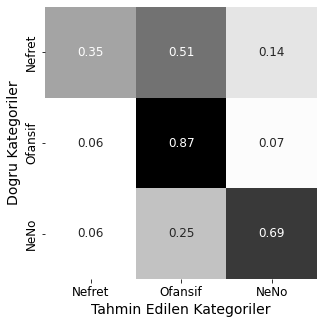

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
# NeNo(Neutral): Ne Nefret Ne Ofansif
names = ['Nefret', 'Ofansif', 'NeNo']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={
                "size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
plt.ylabel(r'Dogru Kategoriler', fontsize=14)
plt.xlabel(r'Tahmin Edilen Kategoriler', fontsize=14)
plt.tick_params(labelsize=12)


# Logistic Regression

In [25]:
model = LogisticRegression(class_weight='balanced',
                           penalty='l2', C=0.01, max_iter=3000).fit(X_train, y_train)


In [26]:
y_preds = model.predict(X_test)


In [27]:
report = classification_report(y_test, y_preds)
print(report)


              precision    recall  f1-score   support

           0       0.23      0.50      0.31       465
           1       0.93      0.80      0.86      6335
           2       0.63      0.78      0.70      1379

    accuracy                           0.78      8179
   macro avg       0.60      0.69      0.62      8179
weighted avg       0.84      0.78      0.80      8179



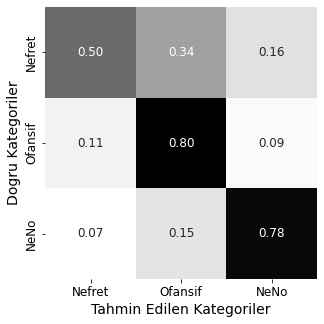

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
# NeNo(Neutral): Ne Nefret Ne Ofansif
names = ['Nefret', 'Ofansif', 'NeNo']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={
                "size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
plt.ylabel(r'Dogru Kategoriler', fontsize=14)
plt.xlabel(r'Tahmin Edilen Kategoriler', fontsize=14)
plt.tick_params(labelsize=12)


# Naive Bayes

In [29]:
# import naive bayes
from sklearn.naive_bayes import BernoulliNB

In [30]:
model = BernoulliNB().fit(X_train, y_train)
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)


              precision    recall  f1-score   support

           0       0.23      0.37      0.28       465
           1       0.89      0.79      0.84      6335
           2       0.51      0.66      0.57      1379

    accuracy                           0.75      8179
   macro avg       0.54      0.61      0.56      8179
weighted avg       0.79      0.75      0.76      8179



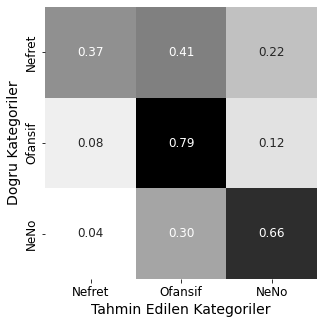

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
# NeNo(Neutral): Ne Nefret Ne Ofansif
names = ['Nefret', 'Ofansif', 'NeNo']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={
                "size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
plt.ylabel(r'Dogru Kategoriler', fontsize=14)
plt.xlabel(r'Tahmin Edilen Kategoriler', fontsize=14)
plt.tick_params(labelsize=12)


# Ensemble Learning / Random Forest

In [32]:
# ENSEMBLE LEARNING
# import ensemble learning
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier().fit(X_train, y_train)
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)


              precision    recall  f1-score   support

           0       0.39      0.03      0.05       465
           1       0.83      0.98      0.90      6335
           2       0.83      0.37      0.51      1379

    accuracy                           0.83      8179
   macro avg       0.68      0.46      0.49      8179
weighted avg       0.80      0.83      0.79      8179



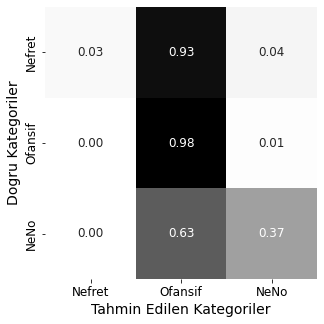

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
# NeNo(Neutral): Ne Nefret Ne Ofansif
names = ['Nefret', 'Ofansif', 'NeNo']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={
                "size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
plt.ylabel(r'Dogru Kategoriler', fontsize=14)
plt.xlabel(r'Tahmin Edilen Kategoriler', fontsize=14)
plt.tick_params(labelsize=12)


# Degerlendirme ve Yorumlama

- Random Forest Classifier %83 oranda accuracy gosterdi. 
- Hem SVC hem de Linear SVC denedik. SVC: %75, LSVC %81 ACC. gosterdi.
- Naive Bayes: %75 acc. gosterdi. Featurelarimiz negatatif degerler iceriyor. Bunlar re-map edilip MultinominalNB / CategoricalNB de denenebilir.
- Logistic Regression ise %78 acc.

Tum bu puanlarin veri setindeki sinif sayilari arasindaki tutarsizlikdan dolayi etkilenecegini dusunuyoruz. 
Bunun disinda featurelarin select edilip tekrar denenmesi performans konusunda fark yaratabilir.